In [1]:
from src import *

## Description

Compute subset groups of gradients and see how stable the extracted gradients are for each movies. 

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

In [2]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [ ]:
mri_path = "./data/fmri400_compiled/"
print(os.listdir(mri_path))

movie_name   = os.listdir(mri_path)[14]
mri_df       = pd.read_csv(mri_path + movie_name)

film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film =  int(film_duration/ TR) # in number of TRs
front_pad     = int(WASH + ONSET) + 1

## Table of Contents
- [Stability](#stable)
    - Stability across movies
    - Stability across subjects

- [Two-Factor ANOVA](#anova)

### STABILITY ACROSS MOVIES

#### Generate gradients from subsets of subjects per movie

In [77]:
subject = 13
permovie = {}
for f in os.listdir('./data/fMRIFiles/TRFiles/'):
    moviename = f.split('_')[-1][:-4]
    if moviename == 'Rest': continue
    if '400' in f and str(subject) in f:
        permovie[moviename] = np.loadtxt('./data/fMRIFiles/TRFiles/{}'.format(f), delimiter=',')

In [78]:
np.random.seed(10)
nb_per_sample = 10
movies = list(permovie.keys())
samples_names = []
samples_grad  = []
nbs = 100
for _ in range(nbs):
    samples_names.append(np.random.choice(movies, nb_per_sample, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series    = permovie[filename_movie]
        movie_series    = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series       = np.concatenate(concat_series)

    fc_movie = FC(concat_series)
    g        = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

save('./resources/sample_gradsubj/'+str(subject) + '_samples.pkl', samples_grad)

100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


In [79]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_gradsubj/'):
    samples_grad.append(load('./resources/sample_gradsubj/'+sample))
    samples_label.append(sample.split('_')[0])

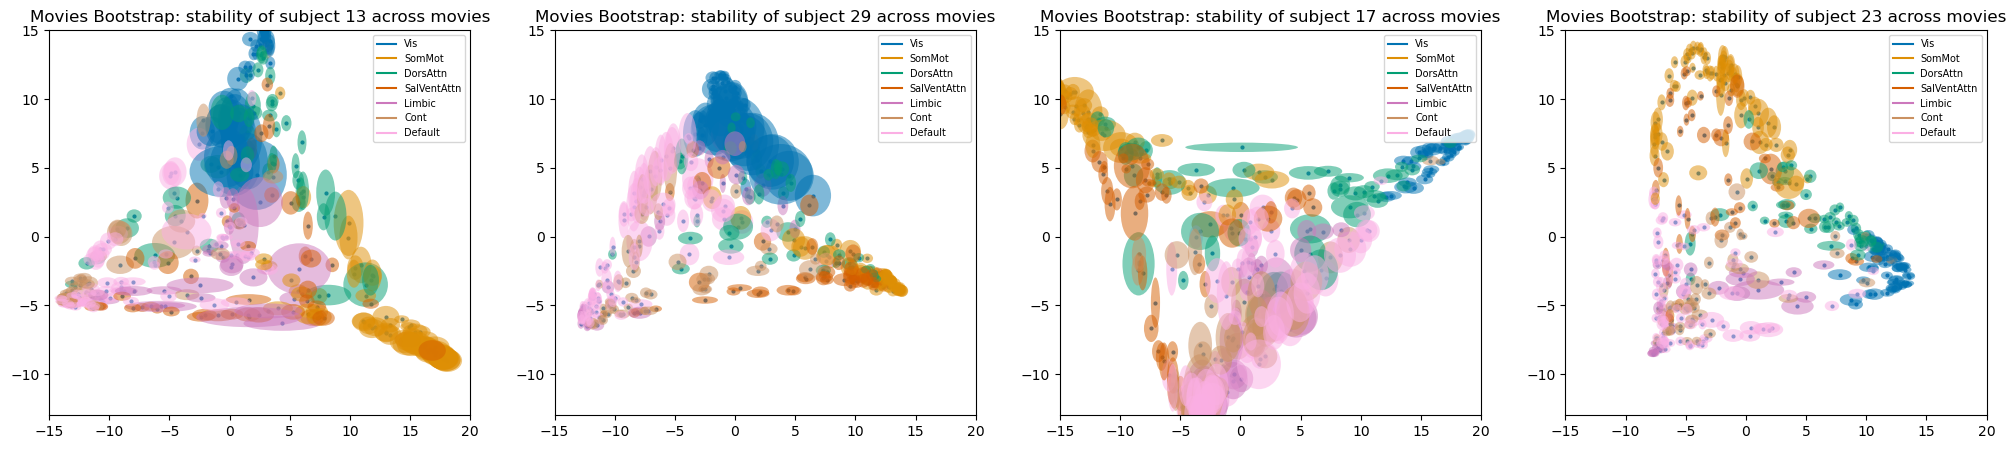

In [81]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}


fig, axes = plt.subplots(1,4, figsize=(25,5))
aligned_samples = []
for k in range(len(samples_grad)):

    aligned,ref      = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    axes[k].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        c   = partial_region[i]
        pts = circle_confusion[i]
        m   = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.5)

        # axes[row,col].add_artist(cc)
        axes[k].add_patch(ellipse)

    axes[k].set_title("Movies Bootstrap: stability of subject {} across movies".format(samples_label[k]), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[k].plot([], [], ls='-', c=c)[0] for c in C]
    axes[k].legend(dummies, labels, loc=1, prop={'size':7})
    axes[k].set_xlim(-15,20)
    axes[k].set_ylim(-13,15)
plt.show()

### STABILITY ACROSS SUBJECTS

#### Generate gradients from subsets of subjects per movie

In [ ]:
nb_per_sample = 25
subjects      = [c for c in mri_df.filename.unique() if '400' in c]
samples_names = []
samples_grad  = []
nbs = 10
for _ in range(nbs):
    samples_names.append(np.random.choice(subjects, nb_per_sample, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series       = np.concatenate(concat_series)

    fc_movie = FC(concat_series)
    g        = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

# save('./resources/sample_grad/'+movie_name.split('_')[0] + '_samples.pkl', samples_grad)

100%|██████████| 10/10 [02:13<00:00, 13.34s/it]


#### Visualize Variance across Sampled Gradients for each Movies

In [73]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_grad/'):
    samples_grad.append(load('./resources/sample_grad/'+sample))
    samples_label.append(sample.split('_')[0])

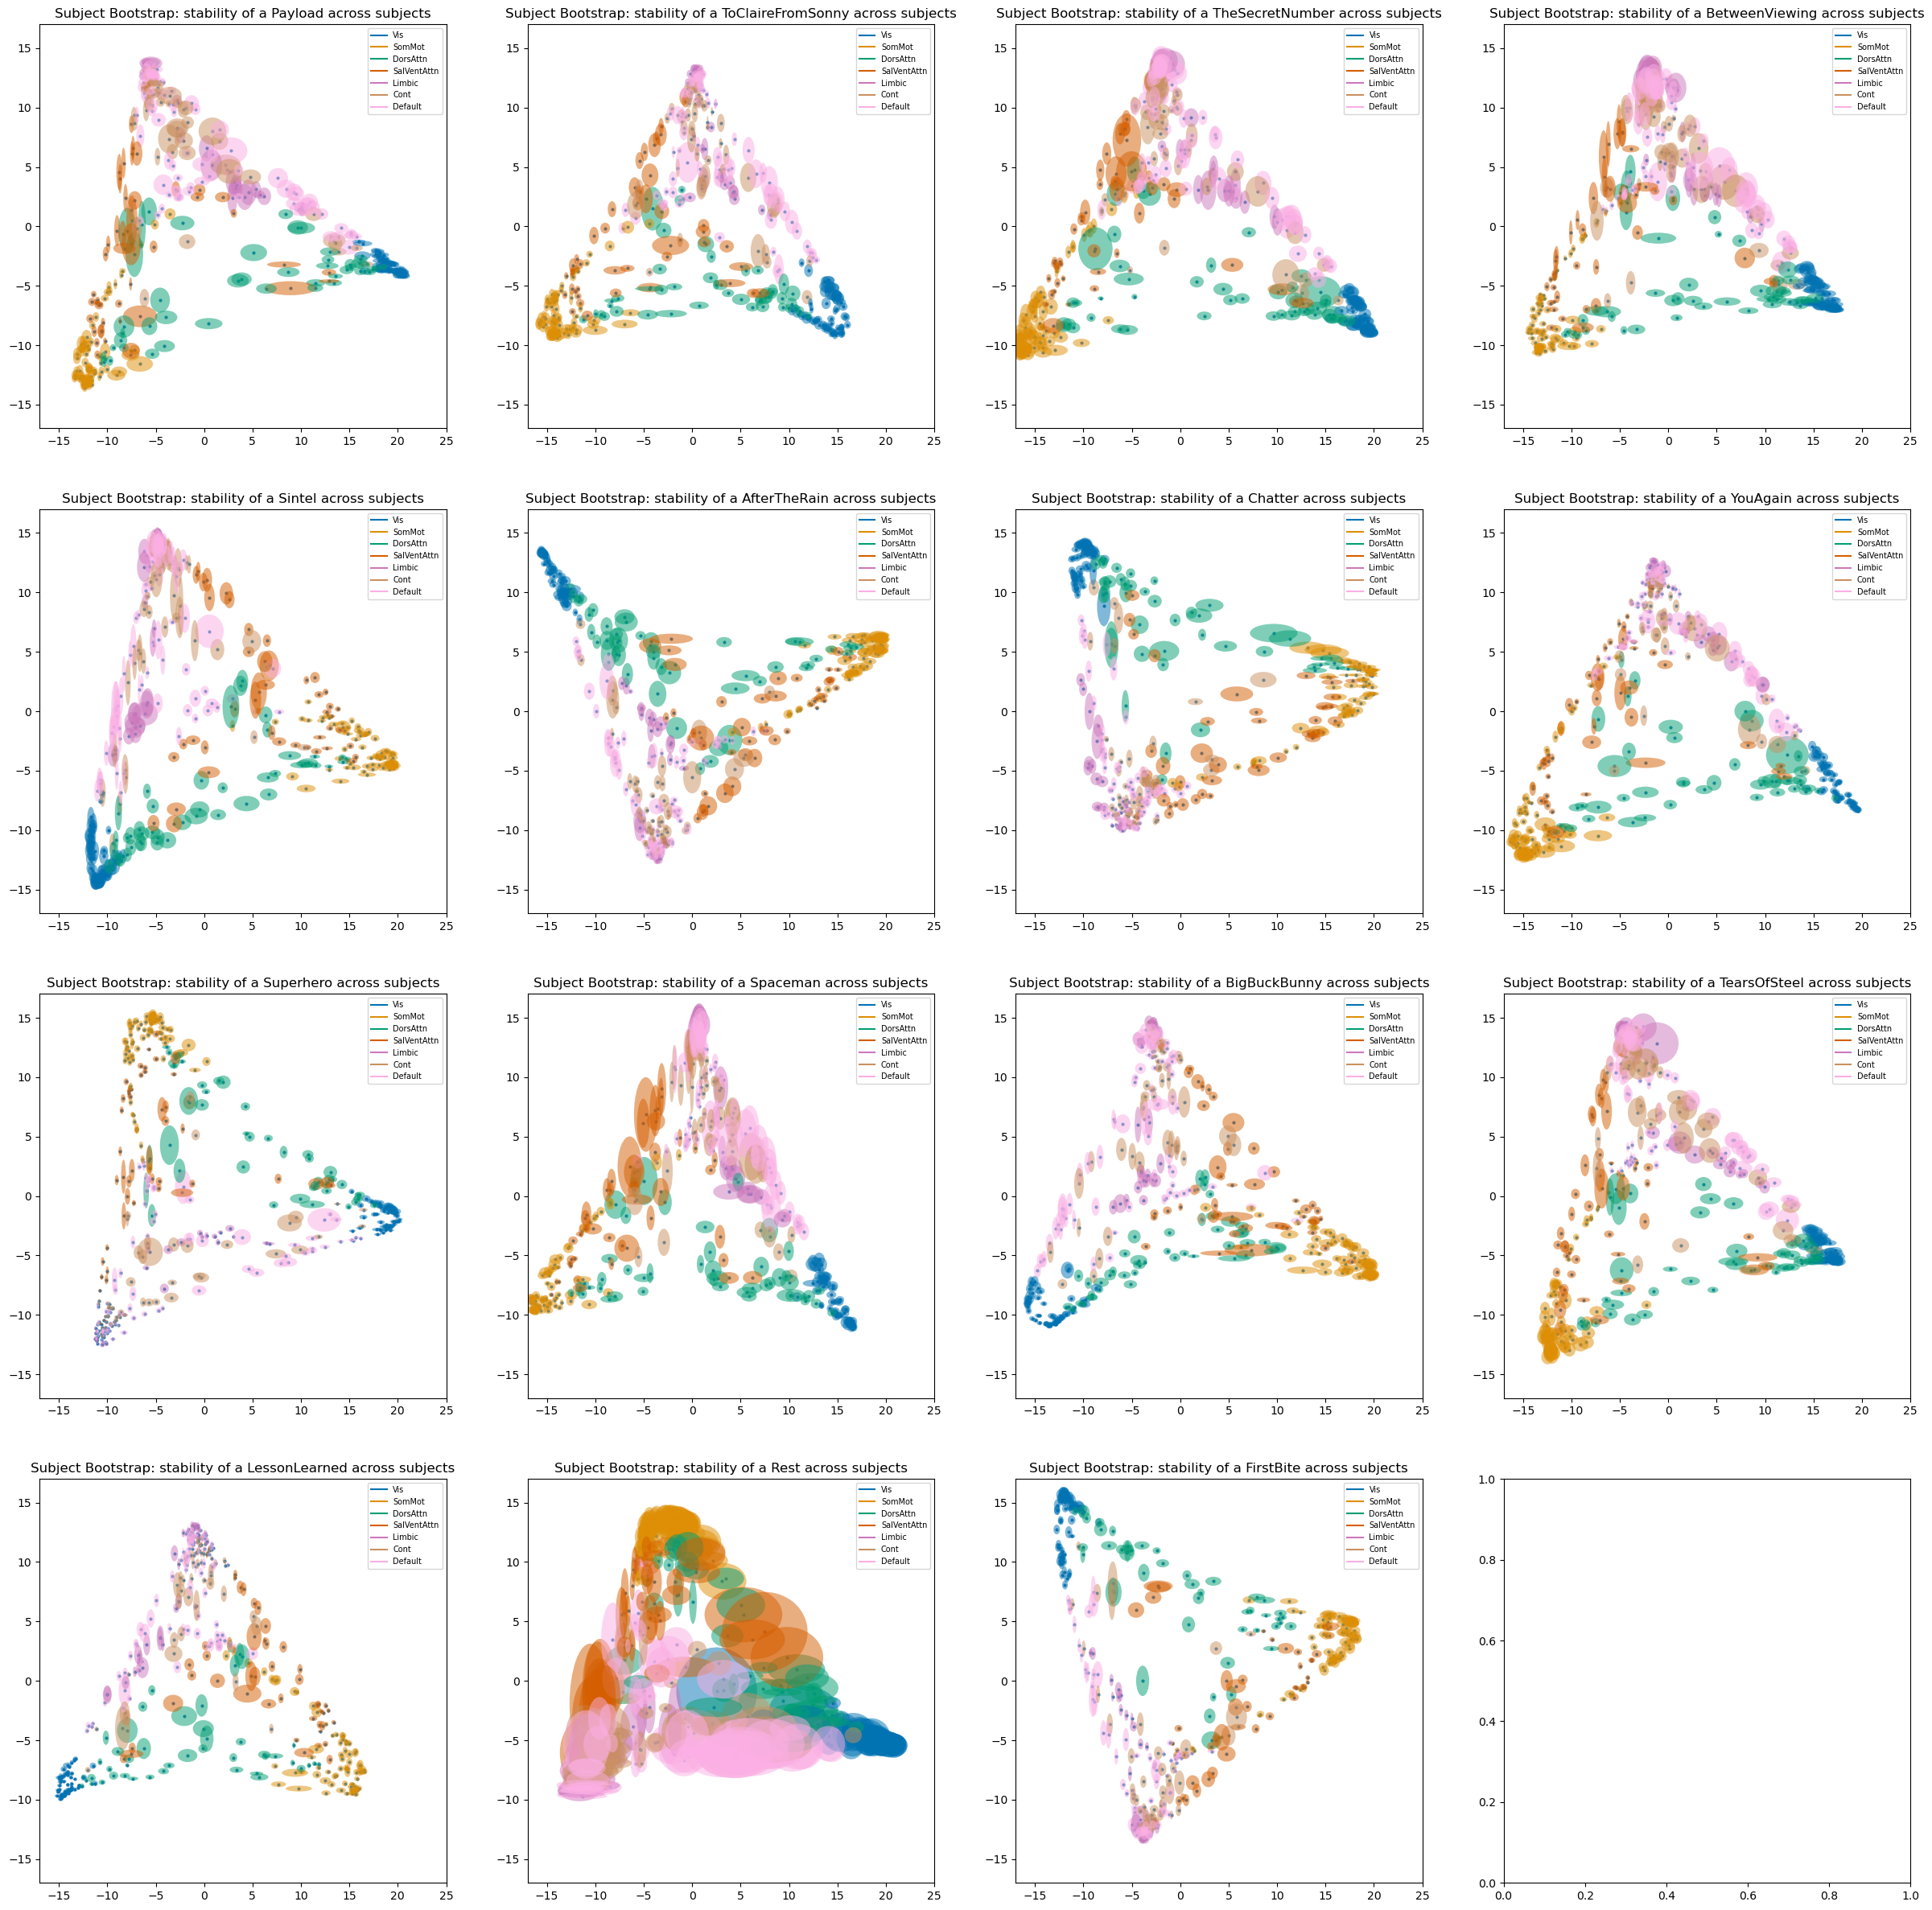

In [74]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}
# colors         = {'Vis': my_cmap.colors[idx], 'Default':'tab:orange', 'Cont':'tab:green', 'DorsAttn':'tab:red', 'Limbic':'tab:purple', 'SalVentAttn': 'tab:brown', 'SomMot': 'tab:pink'}


fig, axes = plt.subplots(4,4, figsize=(30,30))
aligned_samples = []
for k in range(len(samples_grad)):
    row,col = k//4, k%4

    aligned,ref      = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    axes[row,col].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        c   = partial_region[i]
        pts = circle_confusion[i]
        m   = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.5)

        # axes[row,col].add_artist(cc)
        axes[row,col].add_patch(ellipse)

    axes[row,col].set_title("Subject Bootstrap: stability of a {} across subjects".format(samples_label[k]), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in C]
    axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})
    axes[row,col].set_xlim(-17,25)
    axes[row,col].set_ylim(-17,17)

plt.show()

#### Visualize Aggregated variance for each Movies 

(0.0, 4.0)

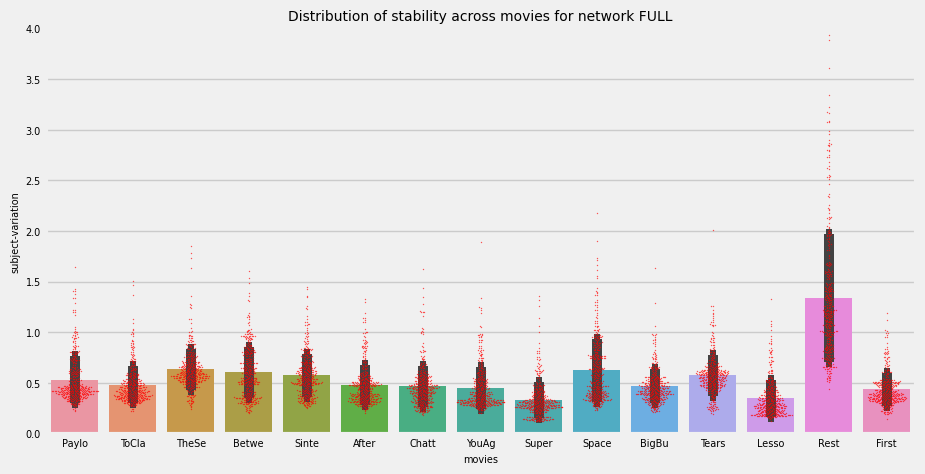

In [14]:
# Close-up view of a full network variation across subjects
fig, ax = plt.subplots(1,1, figsize=(10,5))
distrib = np.asarray(aligned_samples).std(axis=1)[...,[0,1]].mean(axis=-1)
concat_sample_labels  = []
for i in range(len(distrib)):
    concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

sns.barplot(ax=ax, x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(ax=ax, x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
ax.tick_params(labelsize=7)
ax.set_xlabel('movies', fontsize=7)
ax.set_ylabel('subject-variation', fontsize=7)
ax.set_title("Distribution of stability across movies for network {}".format('FULL'), size=10)
ax.set_ylim(0,4)

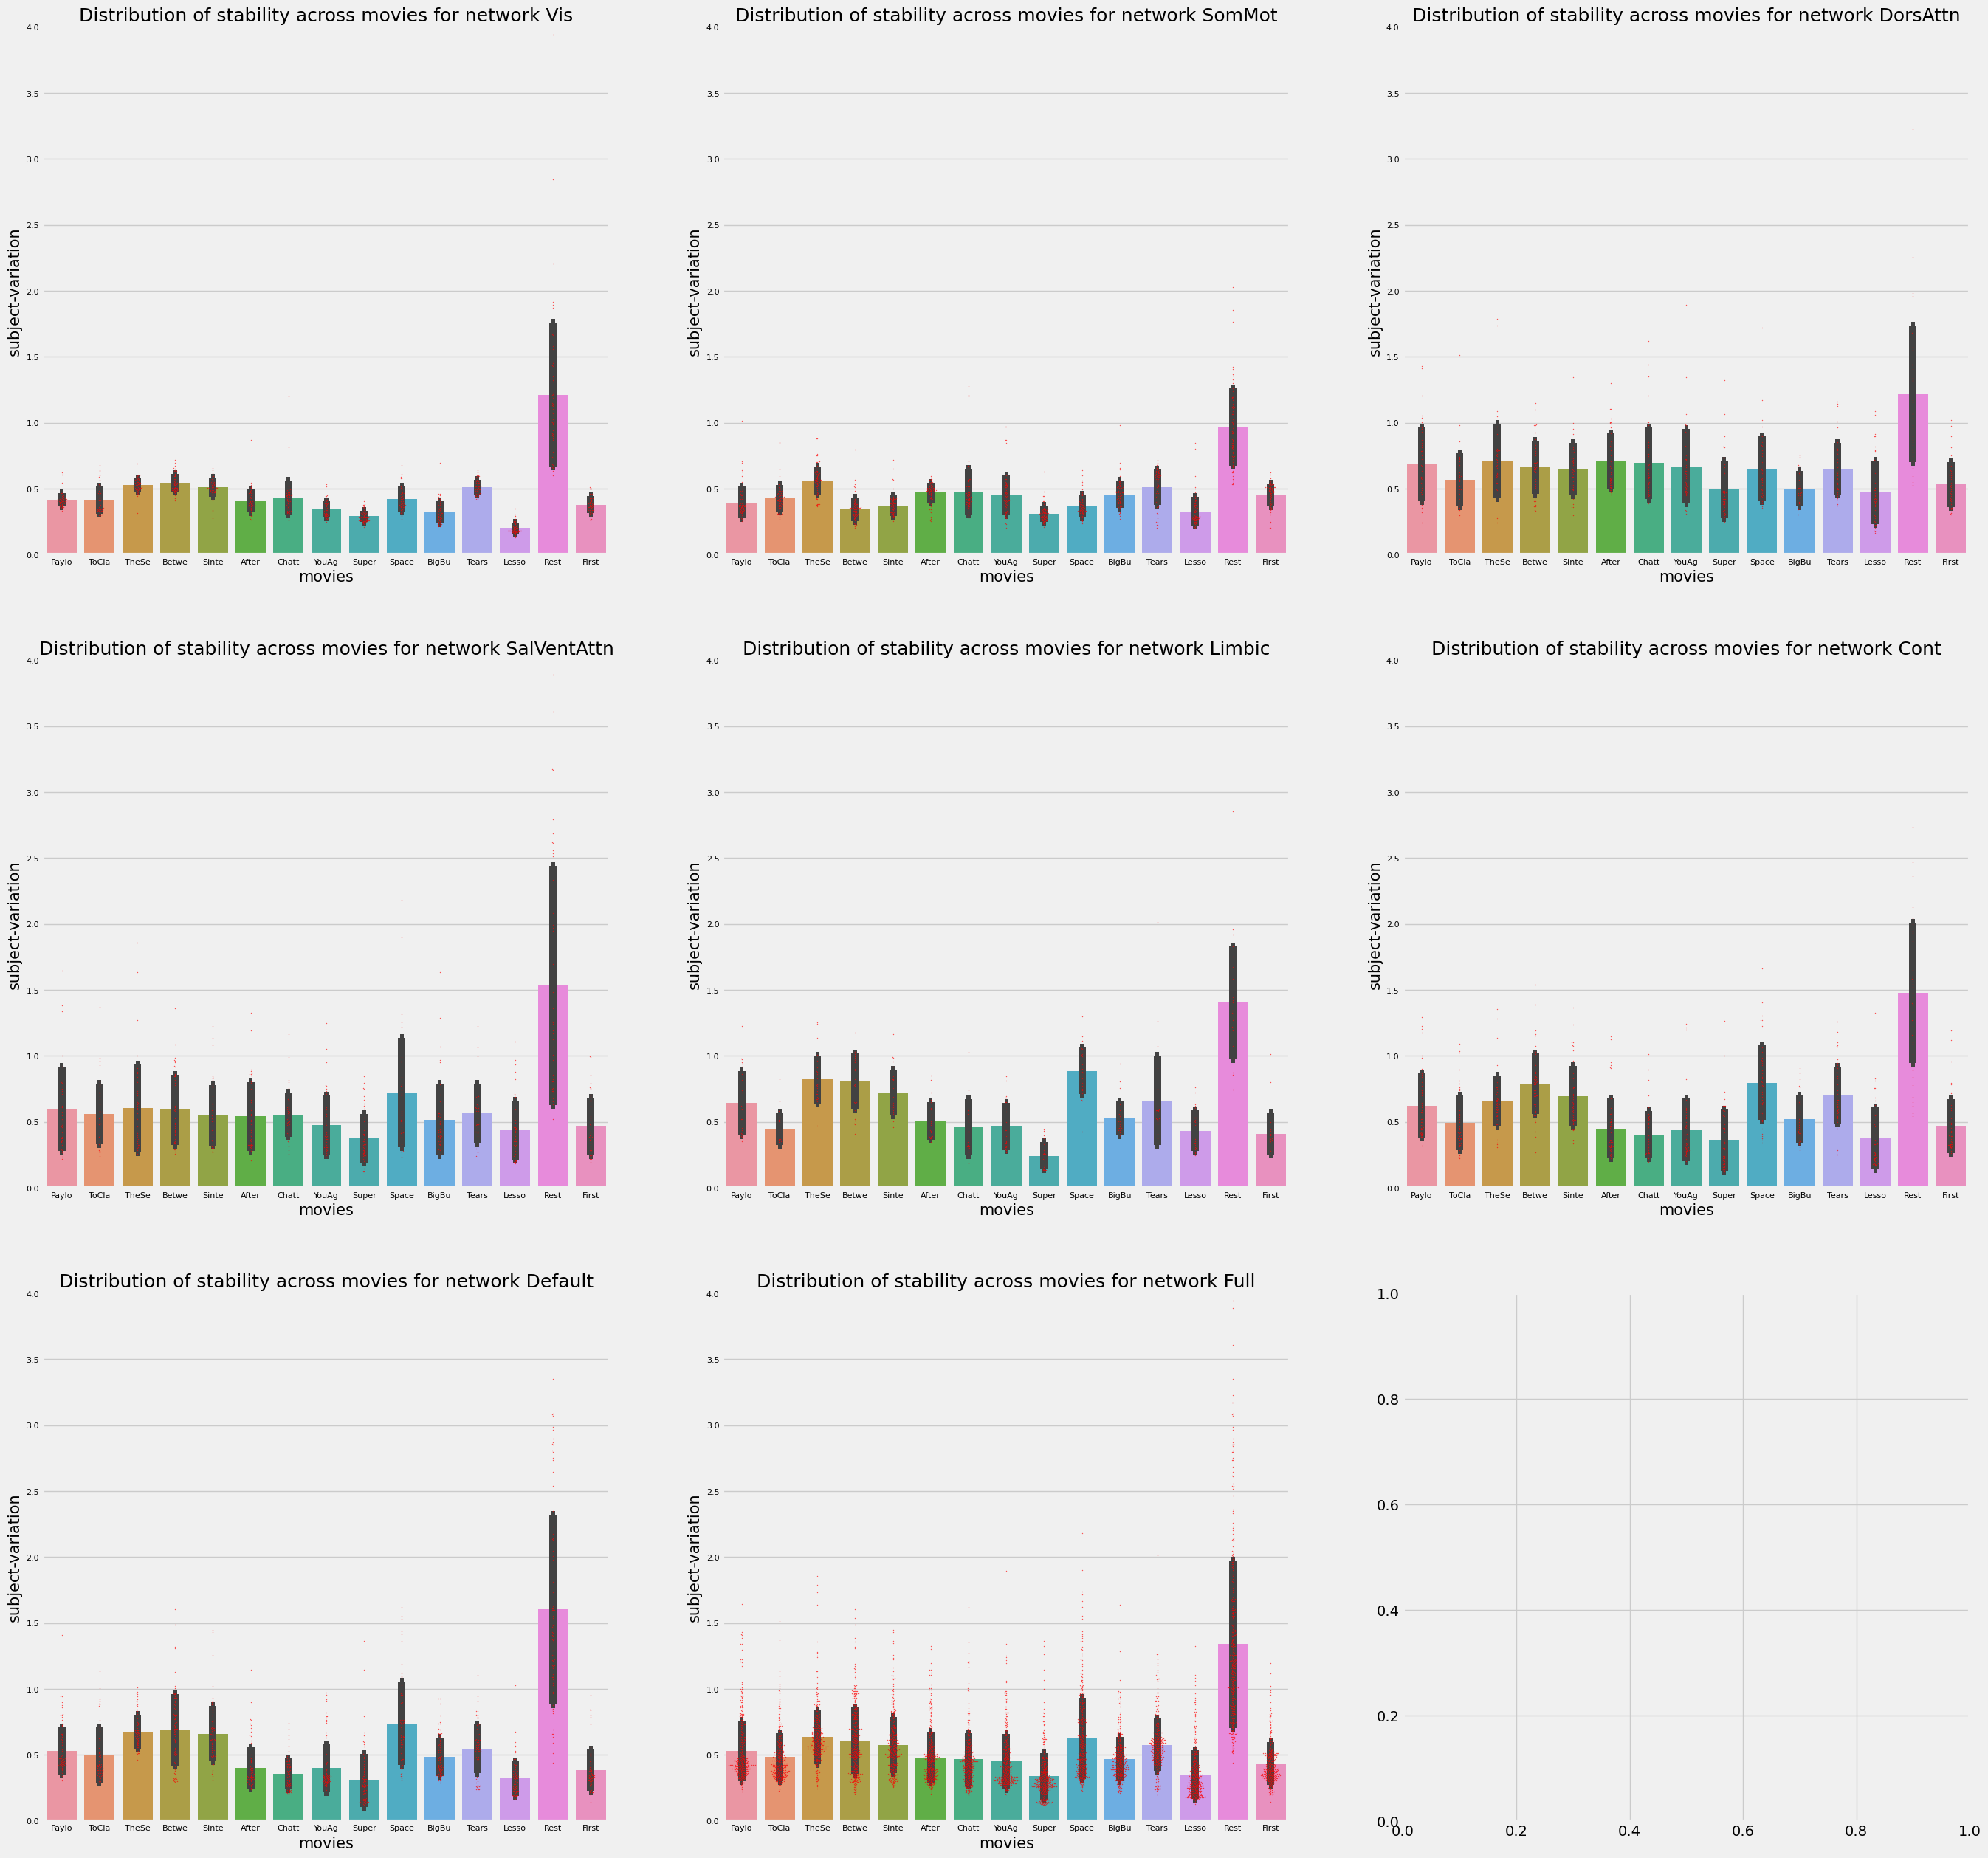

In [15]:
# ALL views of networks variation across subjects
partial_region = load('./resources/yeo7region400.pkl')
fig, ax = plt.subplots(3,3, figsize=(30,30))

for idx,r in enumerate(partial_region):
    row, col = idx//3, idx%3
    distrib = np.asarray(aligned_samples)[:,:,partial_region[r]].std(axis=1)[...,[0,1]].mean(axis=-1)
    concat_sample_labels  = []
    for i in range(len(distrib)):
        concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

    corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

    sns.barplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
    sns.swarmplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
    ax[row,col].tick_params(labelsize=8)
    ax[row,col].set_xlabel('movies', fontsize=15)
    ax[row,col].set_ylabel('subject-variation', fontsize=15)
    ax[row,col].set_title("Distribution of stability across movies for network {}".format(r), size=18)
    ax[row,col].set_ylim(0,4)

idx += 1
row, col = idx//3, idx%3
distrib = np.asarray(aligned_samples).std(axis=1)[...,[0,1]].mean(axis=-1)
concat_sample_labels  = []
for i in range(len(distrib)):
    concat_sample_labels += [samples_label[i][:5]] * distrib.shape[1]

corr_score = {'movies': concat_sample_labels, 'subject-variation': distrib.flatten()}

sns.barplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(ax=ax[row,col], x="movies", y="subject-variation", data=corr_score, color="r", alpha=.65, size=1)
ax[row,col].tick_params(labelsize=8)
ax[row,col].set_xlabel('movies', fontsize=15)
ax[row,col].set_ylabel('subject-variation', fontsize=15)
ax[row,col].set_title("Distribution of stability across movies for network {}".format('Full'), size=18)
ax[row,col].set_ylim(0,4)

plt.show()

### ANOVA One factor (for now) but done twice on the 2 factors "subject" and "movies" 
We plan on investigating why it was possible to do two factor ANOVA on 1 obversvation 

In [12]:
dct = {}
for file in os.listdir('./resources/static_grad/individual_level/'):
    tmp = load('./resources/static_grad/individual_level/'+file)
    dct[file[:-4].split('_')[0]] = tmp

all_grad = [list(k.values()) for k in list(dct.values())]
all_grad = np.asarray(all_grad)[...,:2]
all_grad = np.concatenate(all_grad)

# Compute reference grad to align on 
_, ref, score = procrustes_align(all_grad)

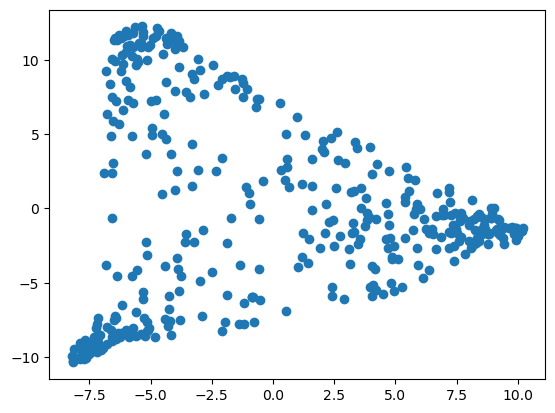

In [49]:
plt.scatter(ref[:,0],ref[:,1])

In [94]:
from bioinfokit.analys import stat

In [142]:
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
df = {"score": [], "Subject": [], "Movie": []}
for m in movies:
    for s in subjects:
        cur_grad = dct[m][s][:,:2]
        cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]
        # df['score'].append(cur_grad[:,1].max()-cur_grad[:,1].min())
        df['score'].append(network_volume(cur_grad, "all"))
        df['Subject'].append(s)
        df['Movie'].append(m)

df = pd.DataFrame.from_dict(df)

In [143]:
res = stat()
res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
# res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Movie),13.0,249.326637,19.178972,2.982089,0.000343
Residual,406.0,2611.144003,6.431389,NaN,NaN


In [144]:
res = stat()
res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
# res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Subject),29.0,1188.264904,40.974652,9.556309,1.564737e-30
Residual,390.0,1672.205735,4.287707,NaN,NaN


#### Post-HOC factor levels effect check

In [145]:
res = stat()
res.tukey_hsd(df=df[['score','Subject']], res_var='score', xfac_var='Subject', anova_model='score ~ C(Subject)')
proc = res.tukey_summary

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


In [152]:
proc[proc['p-value']<0.1]

,group1,group2,Diff,Lower,Upper,q-value,p-value
3,S09,S30,3.720017,0.763642,6.676392,6.721967,0.001079
8,S09,S03,4.947660,1.991285,7.904034,8.940283,0.001000
31,S07,S30,4.025062,1.068687,6.981436,7.273174,0.001000
36,S07,S03,4.642615,1.686240,7.598990,8.389076,0.001000
57,S05,S14,3.584774,0.628400,6.541149,6.477587,0.002309
...,...,...,...,...,...,...,...
380,S17,S15,3.349528,0.393154,6.305903,6.052504,0.008034
387,S17,S23,3.758703,0.802328,6.715077,6.791871,0.001000
393,S15,S08,3.944841,0.988467,6.901216,7.128219,0.001000
422,S08,S23,4.354016,1.397641,7.310390,7.867585,0.001000


In [147]:
res = stat()
res.tukey_hsd(df=df[['score','Movie']], res_var='score', xfac_var='Movie', anova_model='score ~ C(Movie)')
proc2 = res.tukey_summary

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


In [151]:
proc2[proc2['p-value'] < 0.1]
# proc2

,group1,group2,Diff,Lower,Upper,q-value,p-value
13,BetweenViewing,Rest,2.649771,0.440263,4.859279,5.722906,0.004792
26,Rest,Chatter,2.295037,0.085529,4.504545,4.956761,0.033190
27,Rest,YouAgain,2.902551,0.693044,5.112059,6.268854,0.001000
28,Rest,FirstBite,2.361189,0.151682,4.570697,5.099635,0.023741
29,Rest,ToClaireFromSonny,2.706529,0.497021,4.916036,5.845489,0.003410
32,Rest,LessonLearned,2.904948,0.695440,5.114456,6.274030,0.001000
